In [16]:
import numpy as np
import pandas as pd
import yfinance as yf
import talib
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk
import json
# Download necessary NLTK data
nltk.download('vader_lexicon')


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\pande\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [17]:
import yfinance as yf
import talib
import numpy as np

def get_stock_data(ticker):
    # Fetch all available historical data
    data = yf.download(ticker, progress=False)
    
    # Ensure the Close column is a 1D array before passing to TA-Lib
    close_prices = data['Close'].astype(float).values.flatten()

    data['RSI'] = talib.RSI(close_prices, timeperiod=14)
    data['MA_10'] = talib.SMA(close_prices, timeperiod=10)
    data['MA_30'] = talib.SMA(close_prices, timeperiod=30)
    data['MA_50'] = talib.SMA(close_prices, timeperiod=50)
    data['MA_200'] = talib.SMA(close_prices, timeperiod=200)

    upper, middle, lower = talib.BBANDS(close_prices, timeperiod=20)
    data['Upper_Band'] = upper
    data['Lower_Band'] = lower

    data.dropna(inplace=True)
    return data

# Example Usage
df = get_stock_data("TCS.NS")  # Replace with your stock ticker
df.head()  # Display the first few rows


Price,Close,High,Low,Open,Volume,RSI,MA_10,MA_30,MA_50,MA_200,Upper_Band,Lower_Band
Ticker,TCS.NS,TCS.NS,TCS.NS,TCS.NS,TCS.NS,,,,,,,
Date,,,,,,,,,,,,
2003-05-19,28.20125,28.20125,28.20125,28.20125,0,26.580704,28.20125,28.20125,28.894573,31.901115,28.20125,28.20125
2003-05-20,28.20125,28.20125,28.20125,28.20125,0,26.580704,28.20125,28.20125,28.855820,31.896294,28.20125,28.20125
2003-05-21,28.20125,28.20125,28.20125,28.20125,0,26.580704,28.20125,28.20125,28.802558,31.893447,28.20125,28.20125
2003-05-22,28.20125,28.20125,28.20125,28.20125,0,26.580704,28.20125,28.20125,28.758480,31.900518,28.20125,28.20125
2003-05-23,28.20125,28.20125,28.20125,28.20125,0,26.580704,28.20125,28.20125,28.706503,31.907589,28.20125,28.20125


In [18]:
def preprocess_lstm_data(df, columns=['Close'], time_step=60):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(df[columns])
    X, y = [], []
    for i in range(time_step, len(scaled_data)):
        X.append(scaled_data[i-time_step:i])
        y.append(scaled_data[i, 0])
    return np.array(X), np.array(y), scaler

# Build LSTM Model with Optimizations
def build_stacked_lstm_model(input_shape):
    model = Sequential([
        LSTM(128, return_sequences=True, input_shape=input_shape),
        BatchNormalization(),
        Dropout(0.2),
        LSTM(64, return_sequences=True),
        BatchNormalization(),
        Dropout(0.2),
        LSTM(32),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [19]:
def train_lstm_model(X_train, y_train, model_name,epoch):
    model = build_stacked_lstm_model((X_train.shape[1], X_train.shape[2]))
    lr_scheduler = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, min_lr=3.1250e-05, verbose=1)
    model.fit(X_train, y_train, epochs=epoch, batch_size=32, verbose=1, callbacks=[lr_scheduler])
    model.save(f"{model_name}.h5")
    return model

# Sentiment Analysis
def get_sentiment_score(text):
    sia = SentimentIntensityAnalyzer()
    score = sia.polarity_scores(text)['compound']
    return score

In [20]:
import os

# Modified function to append results to JSON
def save_results_to_json(ticker, epoch, rmse, mae, mape, r2, filename='results_all.json'):
    # Check if the file exists and read existing data
    if os.path.isfile(filename):
        with open(filename, 'r') as file:
            try:
                existing_data = json.load(file)
            except json.JSONDecodeError:
                existing_data = []
    else:
        existing_data = []

    # Append new result
    new_result = {
        'Ticker': ticker,
        'Epoch': epoch,
        'RMSE': rmse,
        'MAE': mae,
        'MAPE': mape,
        'R2_Score': r2
    }
    existing_data.append(new_result)

    # Save the updated data back to the file
    with open(filename, 'w') as file:
        json.dump(existing_data, file, indent=4)
    print(f'Results appended to {filename}')

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def forecast_ensemble(ticker, forecast_days=30, epoch=50):
    df = get_stock_data(ticker)
    time_step = 60
    
    # Ensure the correct columns are selected for feature engineering (Only 'Close' for indices)
    feature_columns = ['Close']
    
    # Preprocess data
    X, y, scaler = preprocess_lstm_data(df, columns=feature_columns, time_step=time_step)
    X_train, y_train = X[:-forecast_days], y[:-forecast_days]
    X_test = X[-forecast_days:]

    try:
        model = load_model(f"{ticker}_model.h5")
    except:
        model = train_lstm_model(X_train, y_train, ticker, epoch)

    predictions = model.predict(X_test)

    # Create an empty array for inverse transform with correct shape
    dummy_array = np.zeros((predictions.shape[0], len(feature_columns)))  # (30, 1)
    dummy_array[:, 0] = predictions[:, 0]  # Fill only the Close column

    # Inverse transform using the full shape
    predictions = scaler.inverse_transform(dummy_array)[:, 0]  # Extract only the Close column

    # Inverse transform actual y values
    y_actual = np.zeros((y[-forecast_days:].shape[0], len(feature_columns)))
    y_actual[:, 0] = y[-forecast_days:]  # Fill only the Close column
    y_actual = scaler.inverse_transform(y_actual)[:, 0]  # Extract only Close column

    # Sentiment Adjustment
    headline = f"{ticker} stock market update"
    sentiment_score = get_sentiment_score(headline)
    sentiment_adjustment = 1 + (sentiment_score * 0.03)
    adjusted_preds = predictions * sentiment_adjustment

    # Calculate Evaluation Metrics
    rmse = np.sqrt(mean_squared_error(y_actual, adjusted_preds))
    mae = mean_absolute_error(y_actual, adjusted_preds)
    mape = np.mean(np.abs((y_actual - adjusted_preds) / y_actual)) * 100
    r2 = r2_score(y_actual, adjusted_preds)

    print("RMSE:", rmse)
    print("MAE:", mae)
    print("MAPE:", mape)
    print("R^2 Score:", r2)
    save_results_to_json(ticker, epoch, rmse, mae, mape, r2)
    # Plot Results
    last_dates = df.index[-forecast_days:]
    plt.figure(figsize=(12, 6))
    plt.plot(last_dates, y_actual, label='Actual')
    plt.plot(last_dates, predictions, label='LSTM Forecast')
    plt.plot(last_dates, adjusted_preds, label='Ensemble Forecast (Sentiment)', linestyle='--')
    plt.title(f"{ticker} - Enhanced Ensemble Forecast ({forecast_days} days), {epoch} Epochs")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.show()


In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def forecast_multiple_indices(tickers, forecast_days=30, epoch=50):
    plt.figure(figsize=(12, 6))

    for ticker in tickers:
        df = get_stock_data(ticker)

        # Check if data is empty
        if df.empty:
            print(f"⚠️ Warning: No data found for {ticker}. Skipping...")
            continue

        time_step = 60
        feature_columns = ['Close', 'RSI', 'MA_10', 'MA_30', 'MA_50', 'MA_200', 'Upper_Band', 'Lower_Band']

        # Preprocess Data
        try:
            X, y, scaler = preprocess_lstm_data(df, columns=feature_columns, time_step=time_step)
        except ValueError as e:
            print(f"⚠️ Error processing {ticker}: {e}")
            continue  # Skip this index

        if len(X) == 0 or len(y) == 0:
            print(f"⚠️ Warning: Insufficient data for {ticker}. Skipping...")
            continue

        X_train, y_train = X[:-forecast_days], y[:-forecast_days]
        X_test, y_test = X[-forecast_days:], y[-forecast_days:]

        try:
            model = load_model(f"{ticker}_model.h5")
        except:
            model = train_lstm_model(X_train, y_train, ticker, epoch)

        # Make Predictions
        predictions = model.predict(X_test)
        dummy_array = np.zeros((predictions.shape[0], len(feature_columns)))
        dummy_array[:, 0] = predictions[:, 0]
        predictions = scaler.inverse_transform(dummy_array)[:, 0]

        # Inverse transform actual y values
        y_actual = np.zeros((y_test.shape[0], len(feature_columns)))
        y_actual[:, 0] = y_test
        y_actual = scaler.inverse_transform(y_actual)[:, 0]

        # Compute Metrics
        rmse = np.sqrt(mean_squared_error(y_actual, predictions))
        mae = mean_absolute_error(y_actual, predictions)
        mape = np.mean(np.abs((y_actual - predictions) / y_actual)) * 100
        r2 = r2_score(y_actual, predictions)

        print(f"📊 Performance Metrics for {ticker}:")
        print(f"RMSE: {rmse:.2f}")
        print(f"MAE: {mae:.2f}")
        print(f"MAPE: {mape:.2f}%")
        print(f"R² Score: {r2:.4f}\n")

        # Sentiment Adjustment
        headline = f"{ticker} stock market update"
        sentiment_score = get_sentiment_score(headline)
        sentiment_adjustment = 1 + (sentiment_score * 0.03)
        adjusted_preds = predictions * sentiment_adjustment

        # Plot Results for each Index
        last_dates = df.index[-forecast_days:]
        plt.plot(last_dates, adjusted_preds, label=f"{ticker} Forecast")
        plt.plot(last_dates, y_actual, linestyle="dashed", label=f"{ticker} Actual")

    plt.title(f"Stock Market Forecast vs Actual Data ({forecast_days} days)")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.show()


Epoch 1/50


c:\Users\pande\anaconda3\envs\MachineLearning\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


167/167 ━━━━━━━━━━━━━━━━━━━━ 33s 103ms/step - loss: 0.0357 - learning_rate: 0.0010
Epoch 2/50
167/167 ━━━━━━━━━━━━━━━━━━━━ 21s 128ms/step - loss: 0.0061 - learning_rate: 0.0010
Epoch 3/50
167/167 ━━━━━━━━━━━━━━━━━━━━ 20s 120ms/step - loss: 0.0044 - learning_rate: 0.0010
Epoch 4/50
167/167 ━━━━━━━━━━━━━━━━━━━━ 21s 124ms/step - loss: 0.0033 - learning_rate: 0.0010
Epoch 5/50
167/167 ━━━━━━━━━━━━━━━━━━━━ 21s 124ms/step - loss: 0.0023 - learning_rate: 0.0010
Epoch 6/50
167/167 ━━━━━━━━━━━━━━━━━━━━ 20s 122ms/step - loss: 0.0023 - learning_rate: 0.0010
Epoch 7/50
167/167 ━━━━━━━━━━━━━━━━━━━━ 18s 106ms/step - loss: 0.0015 - learning_rate: 0.0010
Epoch 8/50
167/167 ━━━━━━━━━━━━━━━━━━━━ 20s 121ms/step - loss: 0.0014 - learning_rate: 0.0010
Epoch 9/50
167/167 ━━━━━━━━━━━━━━━━━━━━ 17s 103ms/step - loss: 0.0012 - learning_rate: 0.0010
Epoch 10/50
167/167 ━━━━━━━━━━━━━━━━━━━━ 20s 119ms/step - loss: 0.0012 - learning_rate: 0.0010
Epoch 11/50
167/167 ━━━━━━━━━━━━━━━━━━━━ 17s 100ms/step - loss: 0.0011

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
RMSE: 125.67364667020477
MAE: 101.716110258289
MAPE: 2.8154303296522896
R^2 Score: -0.4920161427041112
Results appended to results_all.json


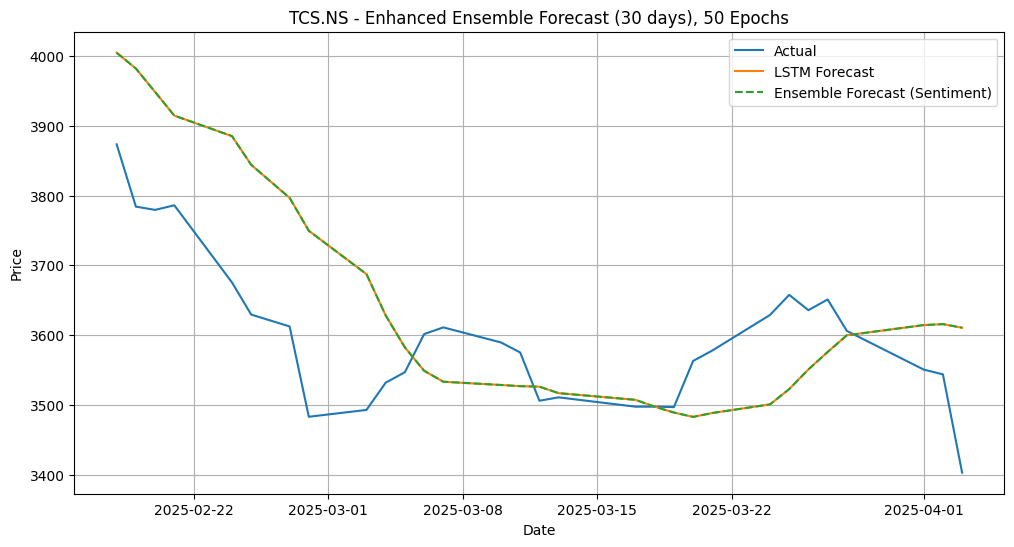

c:\Users\pande\anaconda3\envs\MachineLearning\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
167/167 ━━━━━━━━━━━━━━━━━━━━ 45s 118ms/step - loss: 0.0329 - learning_rate: 0.0010
Epoch 2/100
167/167 ━━━━━━━━━━━━━━━━━━━━ 18s 106ms/step - loss: 0.0052 - learning_rate: 0.0010
Epoch 3/100
167/167 ━━━━━━━━━━━━━━━━━━━━ 20s 119ms/step - loss: 0.0034 - learning_rate: 0.0010
Epoch 4/100
167/167 ━━━━━━━━━━━━━━━━━━━━ 20s 121ms/step - loss: 0.0025 - learning_rate: 0.0010
Epoch 5/100
167/167 ━━━━━━━━━━━━━━━━━━━━ 21s 123ms/step - loss: 0.0021 - learning_rate: 0.0010
Epoch 6/100
167/167 ━━━━━━━━━━━━━━━━━━━━ 20s 121ms/step - loss: 0.0018 - learning_rate: 0.0010
Epoch 7/100
167/167 ━━━━━━━━━━━━━━━━━━━━ 21s 123ms/step - loss: 0.0016 - learning_rate: 0.0010
Epoch 8/100
167/167 ━━━━━━━━━━━━━━━━━━━━ 41s 124ms/step - loss: 0.0013 - learning_rate: 0.0010
Epoch 9/100
167/167 ━━━━━━━━━━━━━━━━━━━━ 22s 128ms/step - loss: 9.6483e-04 - learning_rate: 0.0010
Epoch 10/100
167/167 ━━━━━━━━━━━━━━━━━━━━ 19s 114ms/step - loss: 0.0010 - learning_rate: 0.0010
Epoch 11/100
167/167 ━━━━━━━━━━━━━━━━━━━━ 14s

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
RMSE: 144.26491063063483
MAE: 113.40220119063652
MAPE: 3.15142353620778
R^2 Score: -0.9661041038588105
Results appended to results_all.json


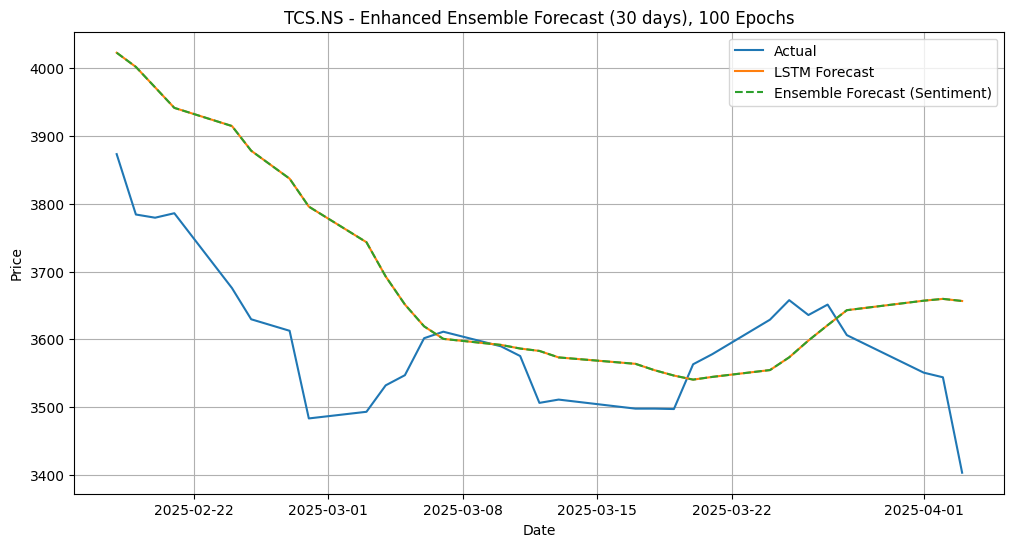

Epoch 1/150


c:\Users\pande\anaconda3\envs\MachineLearning\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


167/167 ━━━━━━━━━━━━━━━━━━━━ 46s 120ms/step - loss: 0.0469 - learning_rate: 0.0010
Epoch 2/150
167/167 ━━━━━━━━━━━━━━━━━━━━ 21s 124ms/step - loss: 0.0061 - learning_rate: 0.0010
Epoch 3/150
167/167 ━━━━━━━━━━━━━━━━━━━━ 41s 123ms/step - loss: 0.0036 - learning_rate: 0.0010
Epoch 4/150
167/167 ━━━━━━━━━━━━━━━━━━━━ 20s 120ms/step - loss: 0.0024 - learning_rate: 0.0010
Epoch 5/150
167/167 ━━━━━━━━━━━━━━━━━━━━ 20s 119ms/step - loss: 0.0020 - learning_rate: 0.0010
Epoch 6/150
167/167 ━━━━━━━━━━━━━━━━━━━━ 16s 94ms/step - loss: 0.0017 - learning_rate: 0.0010
Epoch 7/150
167/167 ━━━━━━━━━━━━━━━━━━━━ 15s 92ms/step - loss: 0.0016 - learning_rate: 0.0010
Epoch 8/150
167/167 ━━━━━━━━━━━━━━━━━━━━ 15s 90ms/step - loss: 0.0014 - learning_rate: 0.0010
Epoch 9/150
167/167 ━━━━━━━━━━━━━━━━━━━━ 17s 101ms/step - loss: 0.0013 - learning_rate: 0.0010
Epoch 10/150
167/167 ━━━━━━━━━━━━━━━━━━━━ 20s 120ms/step - loss: 9.8794e-04 - learning_rate: 0.0010
Epoch 11/150
167/167 ━━━━━━━━━━━━━━━━━━━━ 20s 117ms/step - l

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
RMSE: 93.7347457790148
MAE: 77.49767881819137
MAPE: 2.1831389745377296
R^2 Score: 0.1726156790904526
Results appended to results_all.json


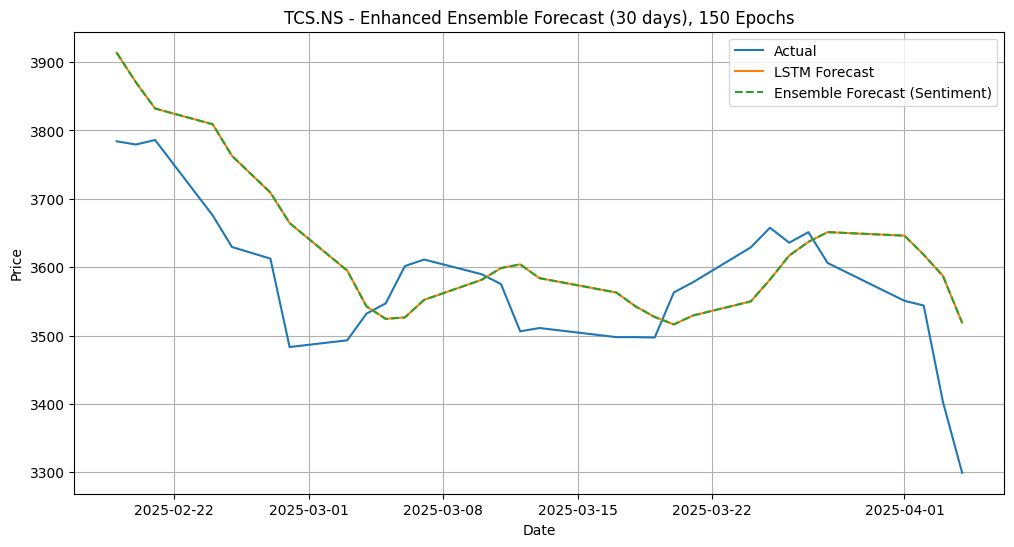

c:\Users\pande\anaconda3\envs\MachineLearning\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
167/167 ━━━━━━━━━━━━━━━━━━━━ 50s 94ms/step - loss: 0.0309 - learning_rate: 0.0010
Epoch 2/200
167/167 ━━━━━━━━━━━━━━━━━━━━ 18s 106ms/step - loss: 0.0059 - learning_rate: 0.0010
Epoch 3/200
167/167 ━━━━━━━━━━━━━━━━━━━━ 19s 115ms/step - loss: 0.0031 - learning_rate: 0.0010
Epoch 4/200
167/167 ━━━━━━━━━━━━━━━━━━━━ 20s 120ms/step - loss: 0.0022 - learning_rate: 0.0010
Epoch 5/200
167/167 ━━━━━━━━━━━━━━━━━━━━ 20s 118ms/step - loss: 0.0019 - learning_rate: 0.0010
Epoch 6/200
167/167 ━━━━━━━━━━━━━━━━━━━━ 20s 120ms/step - loss: 0.0012 - learning_rate: 0.0010
Epoch 7/200
167/167 ━━━━━━━━━━━━━━━━━━━━ 18s 105ms/step - loss: 0.0012 - learning_rate: 0.0010
Epoch 8/200
167/167 ━━━━━━━━━━━━━━━━━━━━ 19s 114ms/step - loss: 0.0010 - learning_rate: 0.0010
Epoch 9/200
167/167 ━━━━━━━━━━━━━━━━━━━━ 20s 120ms/step - loss: 0.0011 - learning_rate: 0.0010
Epoch 10/200
167/167 ━━━━━━━━━━━━━━━━━━━━ 17s 104ms/step - loss: 9.6541e-04 - learning_rate: 0.0010
Epoch 11/200
167/167 ━━━━━━━━━━━━━━━━━━━━ 21s 

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 839ms/step
RMSE: 102.44168058037602
MAE: 82.83584290249259
MAPE: 2.3324212794038086
R^2 Score: 0.011766745349451102
Results appended to results_all.json


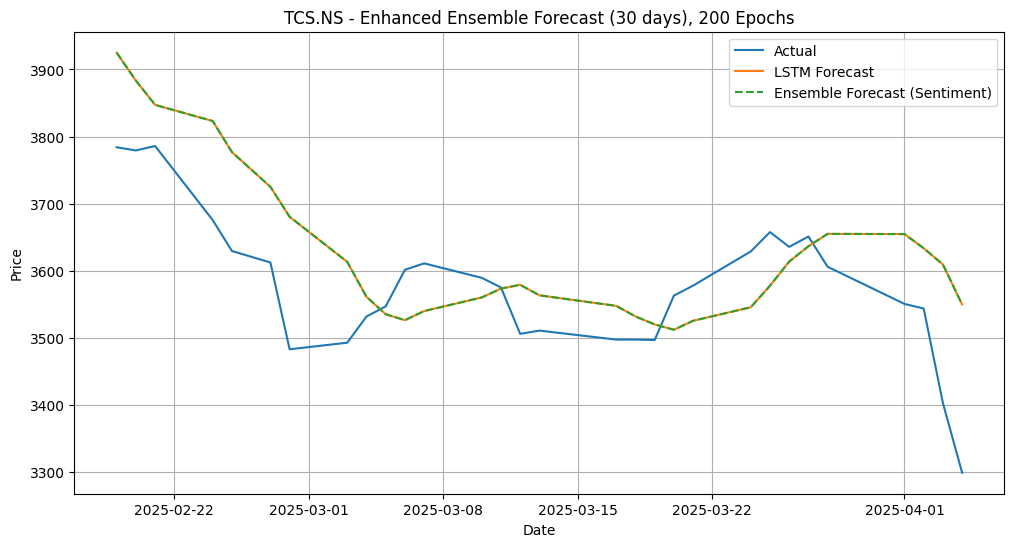

c:\Users\pande\anaconda3\envs\MachineLearning\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/250
167/167 ━━━━━━━━━━━━━━━━━━━━ 27s 102ms/step - loss: 0.0356 - learning_rate: 0.0010
Epoch 2/250
167/167 ━━━━━━━━━━━━━━━━━━━━ 14s 82ms/step - loss: 0.0044 - learning_rate: 0.0010
Epoch 3/250
167/167 ━━━━━━━━━━━━━━━━━━━━ 16s 95ms/step - loss: 0.0029 - learning_rate: 0.0010
Epoch 4/250
167/167 ━━━━━━━━━━━━━━━━━━━━ 16s 98ms/step - loss: 0.0024 - learning_rate: 0.0010
Epoch 5/250
167/167 ━━━━━━━━━━━━━━━━━━━━ 16s 96ms/step - loss: 0.0016 - learning_rate: 0.0010
Epoch 6/250
167/167 ━━━━━━━━━━━━━━━━━━━━ 16s 98ms/step - loss: 0.0018 - learning_rate: 0.0010
Epoch 7/250
167/167 ━━━━━━━━━━━━━━━━━━━━ 16s 98ms/step - loss: 0.0011 - learning_rate: 0.0010
Epoch 8/250
167/167 ━━━━━━━━━━━━━━━━━━━━ 13s 79ms/step - loss: 9.6856e-04 - learning_rate: 0.0010
Epoch 9/250
167/167 ━━━━━━━━━━━━━━━━━━━━ 15s 90ms/step - loss: 9.9748e-04 - learning_rate: 0.0010
Epoch 10/250
167/167 ━━━━━━━━━━━━━━━━━━━━ 16s 96ms/step - loss: 9.8076e-04 - learning_rate: 0.0010
Epoch 11/250
167/167 ━━━━━━━━━━━━━━━━━━━━ 16s 

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
RMSE: 108.54392910027583
MAE: 87.60652276620674
MAPE: 2.4610436644865024
R^2 Score: -0.10947405673441746
Results appended to results_all.json


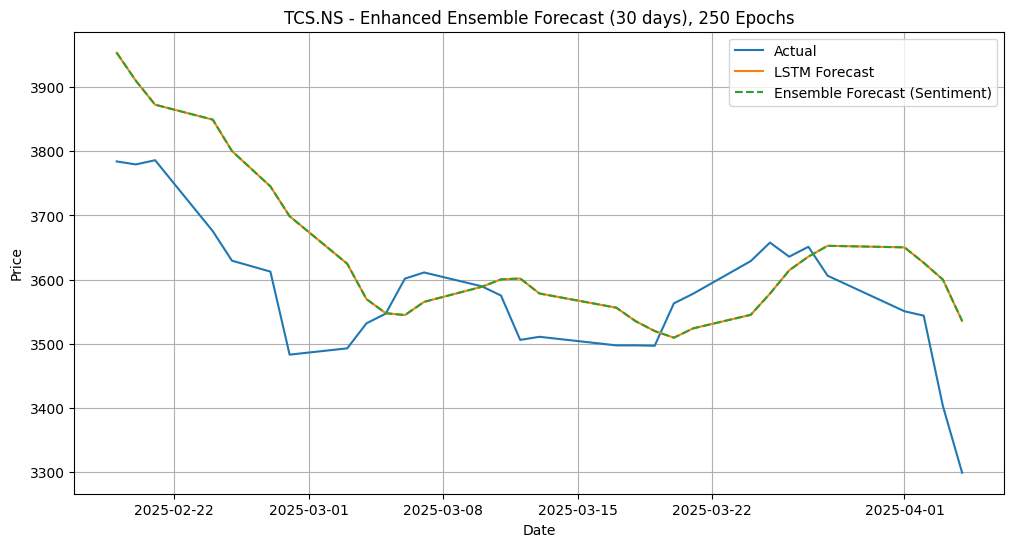

In [23]:
forecast_ensemble("TCS.NS",epoch=50)
forecast_ensemble("TCS.NS",epoch=100)
forecast_ensemble("TCS.NS",epoch=150)
forecast_ensemble("TCS.NS",epoch=200)
forecast_ensemble("TCS.NS",epoch=250)

c:\Users\pande\anaconda3\envs\MachineLearning\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 50s 112ms/step - loss: 0.0343 - learning_rate: 0.0010
Epoch 2/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 23s 104ms/step - loss: 0.0037 - learning_rate: 0.0010
Epoch 3/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 25s 113ms/step - loss: 0.0021 - learning_rate: 0.0010
Epoch 4/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 28s 125ms/step - loss: 0.0016 - learning_rate: 0.0010
Epoch 5/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 46s 146ms/step - loss: 0.0012 - learning_rate: 0.0010
Epoch 6/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 34s 153ms/step - loss: 0.0012 - learning_rate: 0.0010
Epoch 7/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 32s 144ms/step - loss: 9.4908e-04 - learning_rate: 0.0010
Epoch 8/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 33s 148ms/step - loss: 9.0205e-04 - learning_rate: 0.0010
Epoch 9/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 27s 122ms/step - loss: 6.7725e-04 - learning_rate: 0.0010
Epoch 10/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 24s 107ms/step - loss: 7.5920e-04 - learning_rate: 0.0010
Epoch 11/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 27

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
RMSE: 29.3415583027952
MAE: 22.675288889109886
MAPE: 1.8333760566561015
R^2 Score: 0.2548170375369784
Results appended to results_all.json


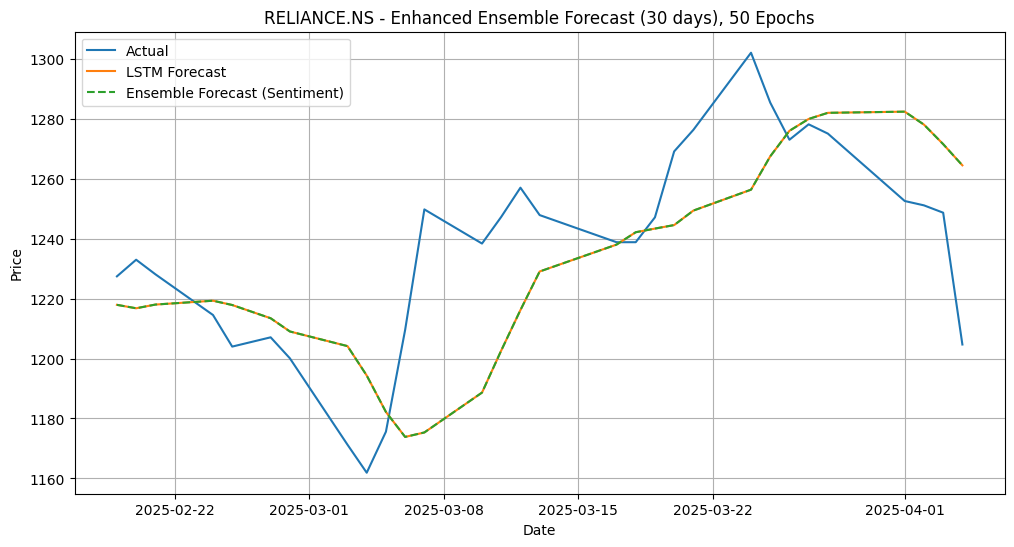

c:\Users\pande\anaconda3\envs\MachineLearning\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
221/221 ━━━━━━━━━━━━━━━━━━━━ 82s 150ms/step - loss: 0.0286 - learning_rate: 0.0010
Epoch 2/100
221/221 ━━━━━━━━━━━━━━━━━━━━ 34s 153ms/step - loss: 0.0037 - learning_rate: 0.0010
Epoch 3/100
221/221 ━━━━━━━━━━━━━━━━━━━━ 34s 155ms/step - loss: 0.0022 - learning_rate: 0.0010
Epoch 4/100
221/221 ━━━━━━━━━━━━━━━━━━━━ 35s 159ms/step - loss: 0.0016 - learning_rate: 0.0010
Epoch 5/100
221/221 ━━━━━━━━━━━━━━━━━━━━ 35s 158ms/step - loss: 0.0016 - learning_rate: 0.0010
Epoch 6/100
221/221 ━━━━━━━━━━━━━━━━━━━━ 33s 150ms/step - loss: 0.0013 - learning_rate: 0.0010
Epoch 7/100
221/221 ━━━━━━━━━━━━━━━━━━━━ 37s 169ms/step - loss: 0.0011 - learning_rate: 0.0010
Epoch 8/100
221/221 ━━━━━━━━━━━━━━━━━━━━ 41s 167ms/step - loss: 0.0011 - learning_rate: 0.0010
Epoch 9/100
221/221 ━━━━━━━━━━━━━━━━━━━━ 36s 161ms/step - loss: 8.9984e-04 - learning_rate: 0.0010
Epoch 10/100
221/221 ━━━━━━━━━━━━━━━━━━━━ 27s 120ms/step - loss: 0.0011 - learning_rate: 0.0010
Epoch 11/100
221/221 ━━━━━━━━━━━━━━━━━━━━ 44s

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
RMSE: 25.938436898830382
MAE: 20.721030333802606
MAPE: 1.686021282866704
R^2 Score: 0.4176498806348413
Results appended to results_all.json


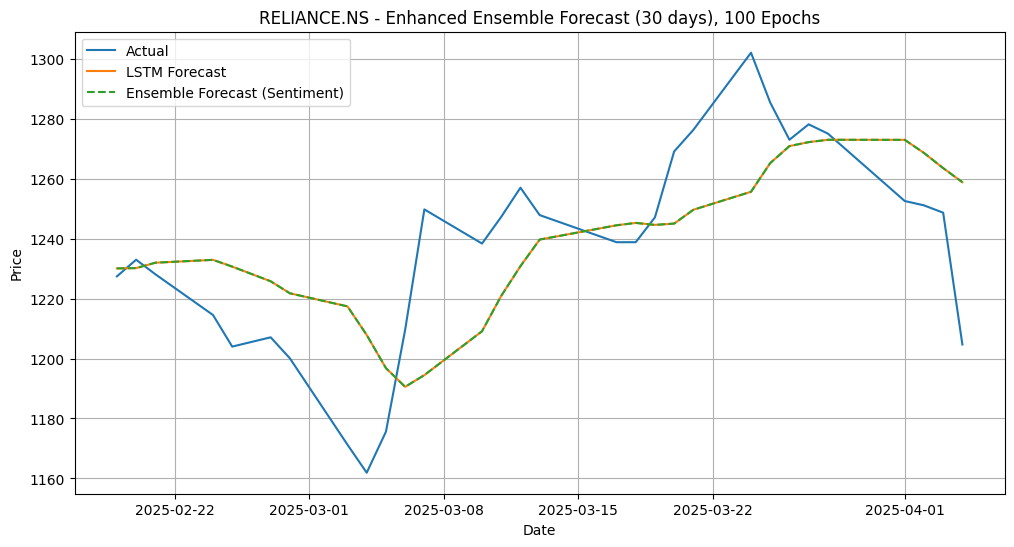

c:\Users\pande\anaconda3\envs\MachineLearning\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/150
221/221 ━━━━━━━━━━━━━━━━━━━━ 84s 163ms/step - loss: 0.0255 - learning_rate: 0.0010
Epoch 2/150
221/221 ━━━━━━━━━━━━━━━━━━━━ 37s 168ms/step - loss: 0.0033 - learning_rate: 0.0010
Epoch 3/150
221/221 ━━━━━━━━━━━━━━━━━━━━ 39s 157ms/step - loss: 0.0022 - learning_rate: 0.0010
Epoch 4/150
221/221 ━━━━━━━━━━━━━━━━━━━━ 34s 153ms/step - loss: 0.0018 - learning_rate: 0.0010
Epoch 5/150
221/221 ━━━━━━━━━━━━━━━━━━━━ 38s 169ms/step - loss: 0.0014 - learning_rate: 0.0010
Epoch 6/150
221/221 ━━━━━━━━━━━━━━━━━━━━ 37s 167ms/step - loss: 9.6479e-04 - learning_rate: 0.0010
Epoch 7/150
221/221 ━━━━━━━━━━━━━━━━━━━━ 43s 173ms/step - loss: 0.0012 - learning_rate: 0.0010
Epoch 8/150
221/221 ━━━━━━━━━━━━━━━━━━━━ 36s 160ms/step - loss: 8.4503e-04 - learning_rate: 0.0010
Epoch 9/150
221/221 ━━━━━━━━━━━━━━━━━━━━ 45s 181ms/step - loss: 7.8847e-04 - learning_rate: 0.0010
Epoch 10/150
221/221 ━━━━━━━━━━━━━━━━━━━━ 37s 160ms/step - loss: 6.7623e-04 - learning_rate: 0.0010
Epoch 11/150
221/221 ━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
RMSE: 25.385012120904598
MAE: 20.846352642875846
MAPE: 1.6961164430805051
R^2 Score: 0.4422349252118405
Results appended to results_all.json


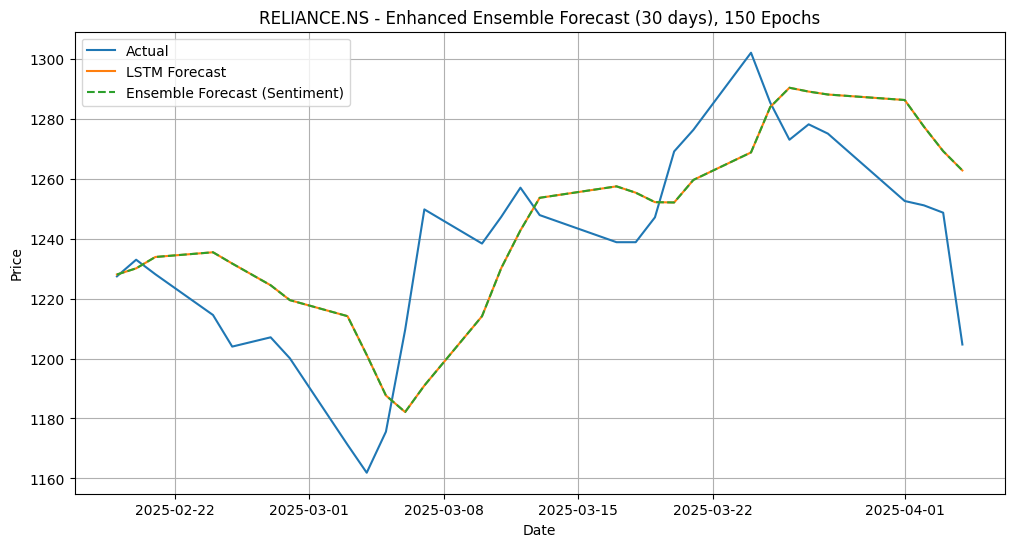

c:\Users\pande\anaconda3\envs\MachineLearning\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
221/221 ━━━━━━━━━━━━━━━━━━━━ 30s 93ms/step - loss: 0.0285 - learning_rate: 0.0010
Epoch 2/200
221/221 ━━━━━━━━━━━━━━━━━━━━ 20s 89ms/step - loss: 0.0037 - learning_rate: 0.0010
Epoch 3/200
221/221 ━━━━━━━━━━━━━━━━━━━━ 20s 90ms/step - loss: 0.0020 - learning_rate: 0.0010
Epoch 4/200
221/221 ━━━━━━━━━━━━━━━━━━━━ 20s 90ms/step - loss: 0.0014 - learning_rate: 0.0010
Epoch 5/200
221/221 ━━━━━━━━━━━━━━━━━━━━ 20s 88ms/step - loss: 0.0014 - learning_rate: 0.0010
Epoch 6/200
221/221 ━━━━━━━━━━━━━━━━━━━━ 20s 89ms/step - loss: 0.0012 - learning_rate: 0.0010
Epoch 7/200
221/221 ━━━━━━━━━━━━━━━━━━━━ 20s 88ms/step - loss: 9.5348e-04 - learning_rate: 0.0010
Epoch 8/200
221/221 ━━━━━━━━━━━━━━━━━━━━ 20s 89ms/step - loss: 8.0482e-04 - learning_rate: 0.0010
Epoch 9/200
221/221 ━━━━━━━━━━━━━━━━━━━━ 19s 86ms/step - loss: 8.7449e-04 - learning_rate: 0.0010
Epoch 10/200
221/221 ━━━━━━━━━━━━━━━━━━━━ 20s 89ms/step - loss: 7.1256e-04 - learning_rate: 0.0010
Epoch 11/200
221/221 ━━━━━━━━━━━━━━━━━━━━ 2

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 892ms/step
RMSE: 24.485932268461067
MAE: 18.055032240240127
MAPE: 1.457763171887669
R^2 Score: 0.48104481635918883
Results appended to results_all.json


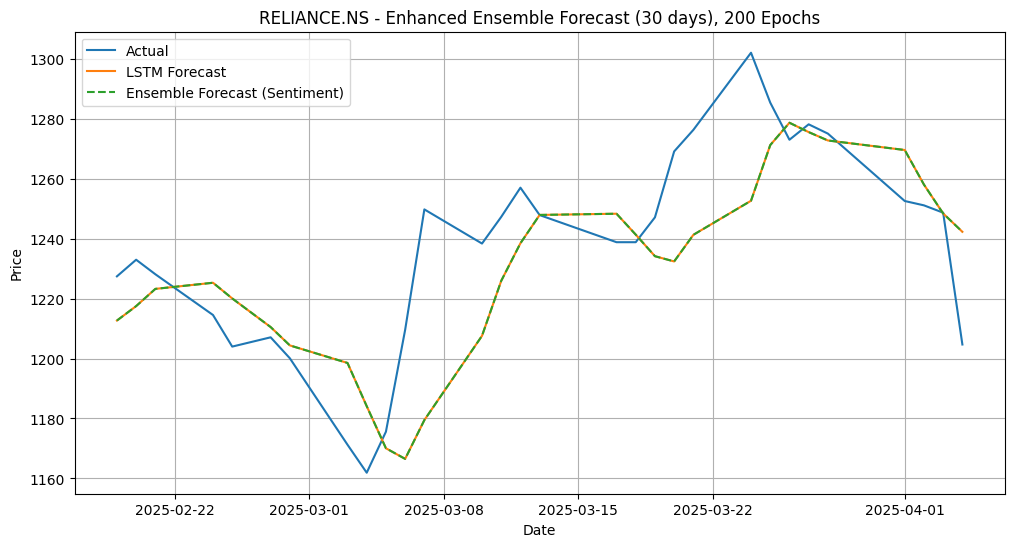

Epoch 1/250


c:\Users\pande\anaconda3\envs\MachineLearning\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


221/221 ━━━━━━━━━━━━━━━━━━━━ 29s 90ms/step - loss: 0.0205 - learning_rate: 0.0010
Epoch 2/250
221/221 ━━━━━━━━━━━━━━━━━━━━ 20s 91ms/step - loss: 0.0031 - learning_rate: 0.0010
Epoch 3/250
221/221 ━━━━━━━━━━━━━━━━━━━━ 20s 89ms/step - loss: 0.0020 - learning_rate: 0.0010
Epoch 4/250
221/221 ━━━━━━━━━━━━━━━━━━━━ 20s 91ms/step - loss: 0.0014 - learning_rate: 0.0010
Epoch 5/250
221/221 ━━━━━━━━━━━━━━━━━━━━ 20s 91ms/step - loss: 0.0012 - learning_rate: 0.0010
Epoch 6/250
221/221 ━━━━━━━━━━━━━━━━━━━━ 20s 92ms/step - loss: 0.0016 - learning_rate: 0.0010
Epoch 7/250
221/221 ━━━━━━━━━━━━━━━━━━━━ 20s 92ms/step - loss: 9.4966e-04 - learning_rate: 0.0010
Epoch 8/250
221/221 ━━━━━━━━━━━━━━━━━━━━ 20s 91ms/step - loss: 8.5019e-04 - learning_rate: 0.0010
Epoch 9/250
221/221 ━━━━━━━━━━━━━━━━━━━━ 20s 92ms/step - loss: 0.0010 - learning_rate: 0.0010
Epoch 10/250
221/221 ━━━━━━━━━━━━━━━━━━━━ 20s 92ms/step - loss: 7.3156e-04 - learning_rate: 0.0010
Epoch 11/250
221/221 ━━━━━━━━━━━━━━━━━━━━ 20s 92ms/step - l

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
RMSE: 23.49978806386064
MAE: 17.09479204694457
MAPE: 1.3793283089119186
R^2 Score: 0.5220037849559069
Results appended to results_all.json


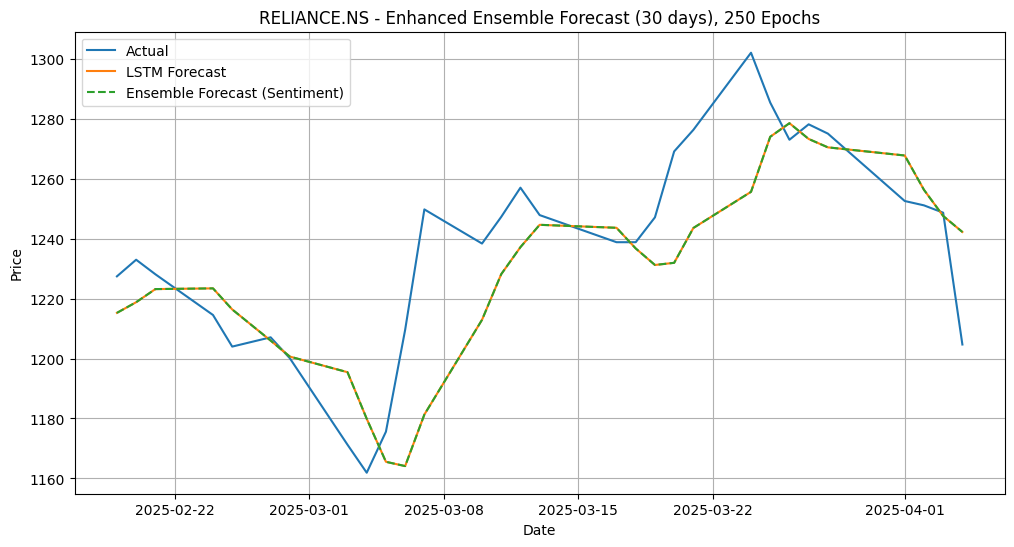

In [24]:

forecast_ensemble("RELIANCE.NS",epoch=50)
forecast_ensemble("RELIANCE.NS",epoch=100)
forecast_ensemble("RELIANCE.NS",epoch=150)
forecast_ensemble("RELIANCE.NS",epoch=200)
forecast_ensemble("RELIANCE.NS",epoch=250)

c:\Users\pande\anaconda3\envs\MachineLearning\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 31s 109ms/step - loss: 0.0495 - learning_rate: 0.0010
Epoch 2/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 12s 95ms/step - loss: 0.0072 - learning_rate: 0.0010
Epoch 3/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 13s 107ms/step - loss: 0.0053 - learning_rate: 0.0010
Epoch 4/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 15s 122ms/step - loss: 0.0029 - learning_rate: 0.0010
Epoch 5/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 13s 104ms/step - loss: 0.0018 - learning_rate: 0.0010
Epoch 6/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 13s 102ms/step - loss: 0.0016 - learning_rate: 0.0010
Epoch 7/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 21s 102ms/step - loss: 0.0013 - learning_rate: 0.0010
Epoch 8/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 18s 140ms/step - loss: 0.0011 - learning_rate: 0.0010
Epoch 9/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 16s 103ms/step - loss: 0.0011 - learning_rate: 0.0010
Epoch 10/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 15s 115ms/step - loss: 8.6192e-04 - learning_rate: 0.0010
Epoch 11/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 13s 106ms/step 

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
📊 Performance Metrics for ^NSEI:
RMSE: 406.78
MAE: 346.48
MAPE: 1.53%
R² Score: 0.2604



c:\Users\pande\anaconda3\envs\MachineLearning\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 22s 89ms/step - loss: 0.0458 - learning_rate: 0.0010
Epoch 2/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 12s 88ms/step - loss: 0.0082 - learning_rate: 0.0010
Epoch 3/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 12s 87ms/step - loss: 0.0033 - learning_rate: 0.0010
Epoch 4/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 12s 88ms/step - loss: 0.0026 - learning_rate: 0.0010
Epoch 5/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 12s 88ms/step - loss: 0.0015 - learning_rate: 0.0010
Epoch 6/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 12s 87ms/step - loss: 0.0013 - learning_rate: 0.0010
Epoch 7/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 12s 87ms/step - loss: 0.0010 - learning_rate: 0.0010
Epoch 8/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 13s 89ms/step - loss: 0.0012 - learning_rate: 0.0010
Epoch 9/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 12s 88ms/step - loss: 8.3454e-04 - learning_rate: 0.0010
Epoch 10/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 12s 88ms/step - loss: 8.3447e-04 - learning_rate: 0.0010
Epoch 11/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 12s 88ms/step - loss

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 946ms/step
📊 Performance Metrics for ^CNX100:
RMSE: 416.33
MAE: 350.01
MAPE: 1.51%
R² Score: 0.3590



c:\Users\pande\anaconda3\envs\MachineLearning\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 22s 97ms/step - loss: 0.0432 - learning_rate: 0.0010
Epoch 2/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 11s 97ms/step - loss: 0.0068 - learning_rate: 0.0010
Epoch 3/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 11s 97ms/step - loss: 0.0048 - learning_rate: 0.0010
Epoch 4/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 12s 99ms/step - loss: 0.0040 - learning_rate: 0.0010
Epoch 5/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 12s 99ms/step - loss: 0.0038 - learning_rate: 0.0010
Epoch 6/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 11s 97ms/step - loss: 0.0029 - learning_rate: 0.0010
Epoch 7/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 11s 98ms/step - loss: 0.0024 - learning_rate: 0.0010
Epoch 8/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 11s 96ms/step - loss: 0.0019 - learning_rate: 0.0010
Epoch 9/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 11s 97ms/step - loss: 0.0020 - learning_rate: 0.0010
Epoch 10/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 11s 96ms/step - loss: 0.0012 - learning_rate: 0.0010
Epoch 11/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 11s 97ms/step - loss: 0.0013

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 855ms/step
📊 Performance Metrics for ^NSEBANK:
RMSE: 711.32
MAE: 581.53
MAPE: 1.17%
R² Score: 0.7271



ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^NSEAUTO']: YFTzMissingError('possibly delisted; no timezone found')


⚠️ Warning: No data found for ^NSEAUTO. Skipping...


ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^NSEIT']: YFTzMissingError('possibly delisted; no timezone found')


⚠️ Warning: No data found for ^NSEIT. Skipping...


ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^NSEMETAL']: YFTzMissingError('possibly delisted; no timezone found')


⚠️ Warning: No data found for ^NSEMETAL. Skipping...


ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^NSEENERGY']: YFTzMissingError('possibly delisted; no timezone found')


⚠️ Warning: No data found for ^NSEENERGY. Skipping...


ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^NSEPHARMA']: YFTzMissingError('possibly delisted; no timezone found')


⚠️ Warning: No data found for ^NSEPHARMA. Skipping...


ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^NSEFMCG']: YFTzMissingError('possibly delisted; no timezone found')


⚠️ Warning: No data found for ^NSEFMCG. Skipping...


ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^NSEPSU']: YFTzMissingError('possibly delisted; no timezone found')


⚠️ Warning: No data found for ^NSEPSU. Skipping...


ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^NSEREALTY']: YFTzMissingError('possibly delisted; no timezone found')


⚠️ Warning: No data found for ^NSEREALTY. Skipping...


ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^NSEINFRA']: YFTzMissingError('possibly delisted; no timezone found')


⚠️ Warning: No data found for ^NSEINFRA. Skipping...


ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^NSEMIDCAP']: YFTzMissingError('possibly delisted; no timezone found')


⚠️ Warning: No data found for ^NSEMIDCAP. Skipping...


ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^NSESMALLCAP']: YFTzMissingError('possibly delisted; no timezone found')


⚠️ Warning: No data found for ^NSESMALLCAP. Skipping...


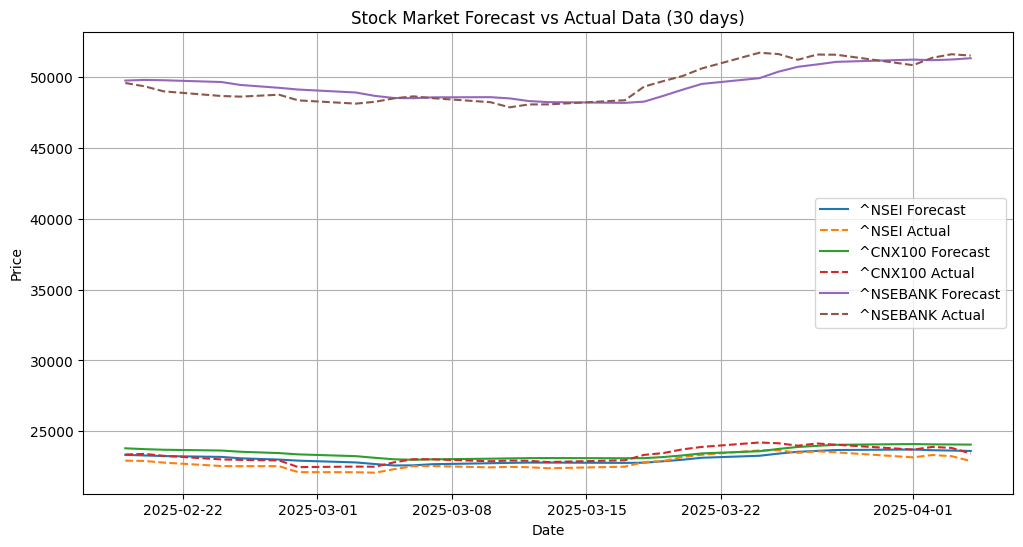

Epoch 1/100


c:\Users\pande\anaconda3\envs\MachineLearning\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


126/126 ━━━━━━━━━━━━━━━━━━━━ 19s 87ms/step - loss: 0.0589 - learning_rate: 0.0010
Epoch 2/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 11s 86ms/step - loss: 0.0062 - learning_rate: 0.0010
Epoch 3/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 11s 86ms/step - loss: 0.0032 - learning_rate: 0.0010
Epoch 4/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 11s 84ms/step - loss: 0.0025 - learning_rate: 0.0010
Epoch 5/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 11s 87ms/step - loss: 0.0016 - learning_rate: 0.0010
Epoch 6/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 20s 87ms/step - loss: 0.0014 - learning_rate: 0.0010
Epoch 7/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 11s 86ms/step - loss: 0.0011 - learning_rate: 0.0010
Epoch 8/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 11s 85ms/step - loss: 0.0011 - learning_rate: 0.0010
Epoch 9/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 11s 86ms/step - loss: 9.4515e-04 - learning_rate: 0.0010
Epoch 10/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 11s 86ms/step - loss: 9.9416e-04 - learning_rate: 0.0010
Epoch 11/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 11s 87ms/step - loss:

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
📊 Performance Metrics for ^NSEI:
RMSE: 310.43
MAE: 259.71
MAPE: 1.14%
R² Score: 0.5693

Epoch 1/100


c:\Users\pande\anaconda3\envs\MachineLearning\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 21s 89ms/step - loss: 0.0352 - learning_rate: 0.0010
Epoch 2/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 12s 87ms/step - loss: 0.0055 - learning_rate: 0.0010
Epoch 3/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 12s 89ms/step - loss: 0.0028 - learning_rate: 0.0010
Epoch 4/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 12s 88ms/step - loss: 0.0020 - learning_rate: 0.0010
Epoch 5/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 12s 87ms/step - loss: 0.0016 - learning_rate: 0.0010
Epoch 6/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 21s 88ms/step - loss: 0.0011 - learning_rate: 0.0010
Epoch 7/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 12s 88ms/step - loss: 9.8487e-04 - learning_rate: 0.0010
Epoch 8/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 21s 88ms/step - loss: 0.0013 - learning_rate: 0.0010
Epoch 9/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 12s 89ms/step - loss: 9.5175e-04 - learning_rate: 0.0010
Epoch 10/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 12s 87ms/step - loss: 7.2903e-04 - learning_rate: 0.0010
Epoch 11/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 12s 88ms/step - l

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step
📊 Performance Metrics for ^CNX100:
RMSE: 448.20
MAE: 380.31
MAPE: 1.64%
R² Score: 0.2571

Epoch 1/100


c:\Users\pande\anaconda3\envs\MachineLearning\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


117/117 ━━━━━━━━━━━━━━━━━━━━ 11s 59ms/step - loss: 0.0562 - learning_rate: 0.0010
Epoch 2/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - loss: 0.0061 - learning_rate: 0.0010
Epoch 3/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - loss: 0.0039 - learning_rate: 0.0010
Epoch 4/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - loss: 0.0039 - learning_rate: 0.0010
Epoch 5/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 7s 63ms/step - loss: 0.0028 - learning_rate: 0.0010
Epoch 6/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - loss: 0.0021 - learning_rate: 0.0010
Epoch 7/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - loss: 0.0018 - learning_rate: 0.0010
Epoch 8/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - loss: 0.0015 - learning_rate: 0.0010
Epoch 9/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 7s 63ms/step - loss: 0.0013 - learning_rate: 0.0010
Epoch 10/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 7s 63ms/step - loss: 0.0011 - learning_rate: 0.0010
Epoch 11/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - loss: 9.4548e-04 - lear

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step


ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^NSEAUTO']: YFTzMissingError('possibly delisted; no timezone found')
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^NSEIT']: YFTzMissingError('possibly delisted; no timezone found')
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^NSEMETAL']: YFTzMissingError('possibly delisted; no timezone found')
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^NSEENERGY']: YFTzMissingError('possibly delisted; no timezone found')
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^NSEPHARMA']: YFTzMissingError('possibly delisted; no timezone found')
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^NSEFMCG']: YFTzMissingError('possibly delisted; no timezone found')
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^NSEPSU']: YFTzMissingError('possibly delisted; no timezone found')
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^NSEREALTY']: YFTzMissingError('possibly delisted; no timezone found')
ERROR:yfinance:
1 Failed dow

📊 Performance Metrics for ^NSEBANK:
RMSE: 850.40
MAE: 751.98
MAPE: 1.53%
R² Score: 0.6099

⚠️ Warning: No data found for ^NSEAUTO. Skipping...
⚠️ Warning: No data found for ^NSEIT. Skipping...
⚠️ Warning: No data found for ^NSEMETAL. Skipping...
⚠️ Warning: No data found for ^NSEENERGY. Skipping...
⚠️ Warning: No data found for ^NSEPHARMA. Skipping...
⚠️ Warning: No data found for ^NSEFMCG. Skipping...
⚠️ Warning: No data found for ^NSEPSU. Skipping...
⚠️ Warning: No data found for ^NSEREALTY. Skipping...


ERROR:yfinance:['^NSEINFRA']: YFTzMissingError('possibly delisted; no timezone found')


⚠️ Warning: No data found for ^NSEINFRA. Skipping...


ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^NSEMIDCAP']: YFTzMissingError('possibly delisted; no timezone found')
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^NSESMALLCAP']: YFTzMissingError('possibly delisted; no timezone found')


⚠️ Warning: No data found for ^NSEMIDCAP. Skipping...
⚠️ Warning: No data found for ^NSESMALLCAP. Skipping...


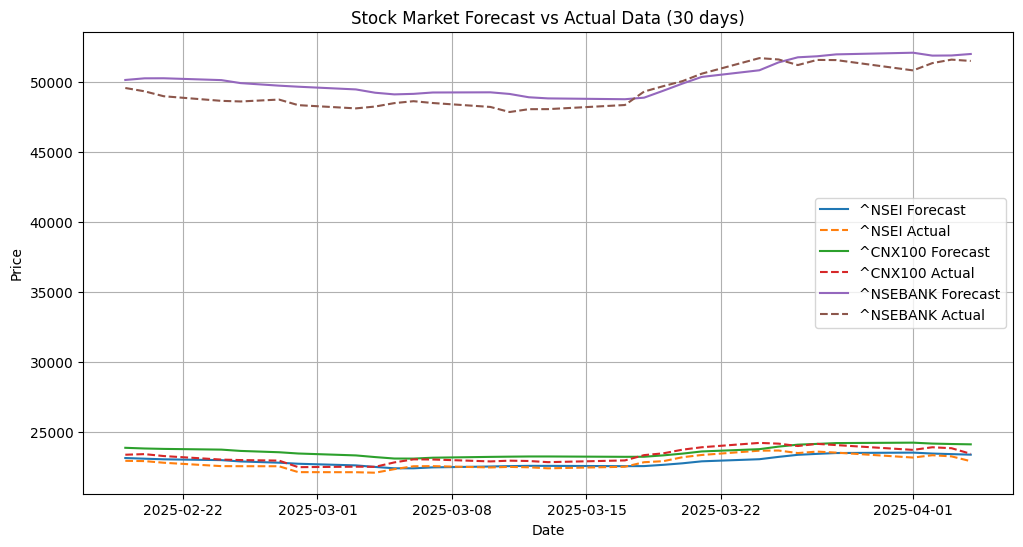

Epoch 1/150


c:\Users\pande\anaconda3\envs\MachineLearning\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


126/126 ━━━━━━━━━━━━━━━━━━━━ 11s 58ms/step - loss: 0.0449 - learning_rate: 0.0010
Epoch 2/150
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - loss: 0.0064 - learning_rate: 0.0010
Epoch 3/150
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - loss: 0.0035 - learning_rate: 0.0010
Epoch 4/150
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - loss: 0.0028 - learning_rate: 0.0010
Epoch 5/150
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - loss: 0.0023 - learning_rate: 0.0010
Epoch 6/150
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - loss: 0.0017 - learning_rate: 0.0010
Epoch 7/150
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - loss: 0.0016 - learning_rate: 0.0010
Epoch 8/150
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step - loss: 0.0014 - learning_rate: 0.0010
Epoch 9/150
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - loss: 0.0012 - learning_rate: 0.0010
Epoch 10/150
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - loss: 9.4904e-04 - learning_rate: 0.0010
Epoch 11/150
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step - loss: 7.6303e-04 - 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step
📊 Performance Metrics for ^NSEI:
RMSE: 286.80
MAE: 241.69
MAPE: 1.06%
R² Score: 0.6323

Epoch 1/150


c:\Users\pande\anaconda3\envs\MachineLearning\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 12s 57ms/step - loss: 0.0399 - learning_rate: 0.0010
Epoch 2/150
140/140 ━━━━━━━━━━━━━━━━━━━━ 9s 67ms/step - loss: 0.0043 - learning_rate: 0.0010
Epoch 3/150
140/140 ━━━━━━━━━━━━━━━━━━━━ 9s 62ms/step - loss: 0.0024 - learning_rate: 0.0010
Epoch 4/150
140/140 ━━━━━━━━━━━━━━━━━━━━ 9s 62ms/step - loss: 0.0016 - learning_rate: 0.0010
Epoch 5/150
140/140 ━━━━━━━━━━━━━━━━━━━━ 9s 63ms/step - loss: 0.0013 - learning_rate: 0.0010
Epoch 6/150
140/140 ━━━━━━━━━━━━━━━━━━━━ 9s 64ms/step - loss: 0.0012 - learning_rate: 0.0010
Epoch 7/150
140/140 ━━━━━━━━━━━━━━━━━━━━ 9s 62ms/step - loss: 9.9008e-04 - learning_rate: 0.0010
Epoch 8/150
140/140 ━━━━━━━━━━━━━━━━━━━━ 9s 62ms/step - loss: 8.0088e-04 - learning_rate: 0.0010
Epoch 9/150
140/140 ━━━━━━━━━━━━━━━━━━━━ 9s 63ms/step - loss: 6.5148e-04 - learning_rate: 0.0010
Epoch 10/150
140/140 ━━━━━━━━━━━━━━━━━━━━ 9s 63ms/step - loss: 6.8858e-04 - learning_rate: 0.0010
Epoch 11/150
140/140 ━━━━━━━━━━━━━━━━━━━━ 9s 62ms/step - loss: 6

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step
📊 Performance Metrics for ^CNX100:
RMSE: 273.72
MAE: 222.31
MAPE: 0.95%
R² Score: 0.7229

Epoch 1/150


c:\Users\pande\anaconda3\envs\MachineLearning\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


117/117 ━━━━━━━━━━━━━━━━━━━━ 11s 58ms/step - loss: 0.0628 - learning_rate: 0.0010
Epoch 2/150
117/117 ━━━━━━━━━━━━━━━━━━━━ 7s 61ms/step - loss: 0.0073 - learning_rate: 0.0010
Epoch 3/150
117/117 ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/step - loss: 0.0043 - learning_rate: 0.0010
Epoch 4/150
117/117 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - loss: 0.0036 - learning_rate: 0.0010
Epoch 5/150
117/117 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - loss: 0.0024 - learning_rate: 0.0010
Epoch 6/150
117/117 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - loss: 0.0020 - learning_rate: 0.0010
Epoch 7/150
117/117 ━━━━━━━━━━━━━━━━━━━━ 7s 63ms/step - loss: 0.0019 - learning_rate: 0.0010
Epoch 8/150
117/117 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - loss: 0.0016 - learning_rate: 0.0010
Epoch 9/150
117/117 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - loss: 0.0016 - learning_rate: 0.0010
Epoch 10/150
117/117 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - loss: 0.0011 - learning_rate: 0.0010
Epoch 11/150
117/117 ━━━━━━━━━━━━━━━━━━━━ 7s 63ms/step - loss: 0.0012 - learning

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step


ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^NSEAUTO']: YFTzMissingError('possibly delisted; no timezone found')
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^NSEIT']: YFTzMissingError('possibly delisted; no timezone found')
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^NSEMETAL']: YFTzMissingError('possibly delisted; no timezone found')
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^NSEENERGY']: YFTzMissingError('possibly delisted; no timezone found')
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^NSEPHARMA']: YFTzMissingError('possibly delisted; no timezone found')
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^NSEFMCG']: YFTzMissingError('possibly delisted; no timezone found')
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^NSEPSU']: YFTzMissingError('possibly delisted; no timezone found')
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^NSEREALTY']: YFTzMissingError('possibly delisted; no timezone found')
ERROR:yfinance:
1 Failed dow

📊 Performance Metrics for ^NSEBANK:
RMSE: 653.91
MAE: 502.91
MAPE: 1.01%
R² Score: 0.7693

⚠️ Warning: No data found for ^NSEAUTO. Skipping...
⚠️ Warning: No data found for ^NSEIT. Skipping...
⚠️ Warning: No data found for ^NSEMETAL. Skipping...
⚠️ Warning: No data found for ^NSEENERGY. Skipping...
⚠️ Warning: No data found for ^NSEPHARMA. Skipping...
⚠️ Warning: No data found for ^NSEFMCG. Skipping...
⚠️ Warning: No data found for ^NSEPSU. Skipping...
⚠️ Warning: No data found for ^NSEREALTY. Skipping...


ERROR:yfinance:['^NSEINFRA']: YFTzMissingError('possibly delisted; no timezone found')


⚠️ Warning: No data found for ^NSEINFRA. Skipping...

ERROR:yfinance:
1 Failed download:


ERROR:yfinance:['^NSEMIDCAP']: YFTzMissingError('possibly delisted; no timezone found')
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^NSESMALLCAP']: YFTzMissingError('possibly delisted; no timezone found')


⚠️ Warning: No data found for ^NSEMIDCAP. Skipping...
⚠️ Warning: No data found for ^NSESMALLCAP. Skipping...


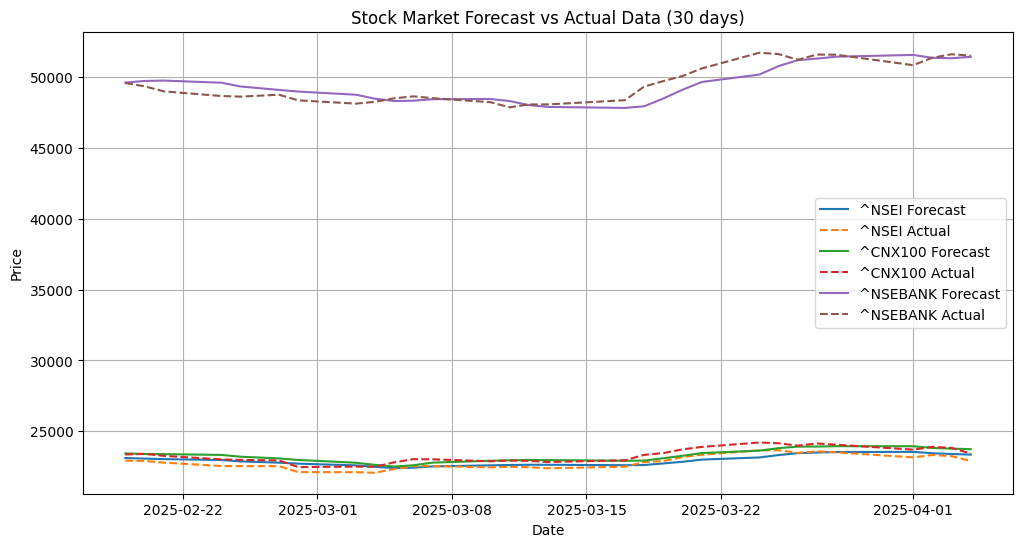

Epoch 1/200


c:\Users\pande\anaconda3\envs\MachineLearning\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


126/126 ━━━━━━━━━━━━━━━━━━━━ 12s 58ms/step - loss: 0.0518 - learning_rate: 0.0010
Epoch 2/200
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - loss: 0.0071 - learning_rate: 0.0010
Epoch 3/200
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step - loss: 0.0046 - learning_rate: 0.0010
Epoch 4/200
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step - loss: 0.0024 - learning_rate: 0.0010
Epoch 5/200
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step - loss: 0.0018 - learning_rate: 0.0010
Epoch 6/200
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - loss: 0.0018 - learning_rate: 0.0010
Epoch 7/200
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 64ms/step - loss: 0.0018 - learning_rate: 0.0010
Epoch 8/200
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - loss: 0.0011 - learning_rate: 0.0010
Epoch 9/200
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step - loss: 0.0011 - learning_rate: 0.0010
Epoch 10/200
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step - loss: 9.1525e-04 - learning_rate: 0.0010
Epoch 11/200
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step - loss: 7.9589e-04 - 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step
📊 Performance Metrics for ^NSEI:
RMSE: 252.01
MAE: 195.38
MAPE: 0.85%
R² Score: 0.7161

Epoch 1/200


c:\Users\pande\anaconda3\envs\MachineLearning\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 12s 59ms/step - loss: 0.0472 - learning_rate: 0.0010
Epoch 2/200
140/140 ━━━━━━━━━━━━━━━━━━━━ 9s 63ms/step - loss: 0.0051 - learning_rate: 0.0010
Epoch 3/200
140/140 ━━━━━━━━━━━━━━━━━━━━ 9s 64ms/step - loss: 0.0034 - learning_rate: 0.0010
Epoch 4/200
140/140 ━━━━━━━━━━━━━━━━━━━━ 9s 63ms/step - loss: 0.0019 - learning_rate: 0.0010
Epoch 5/200
140/140 ━━━━━━━━━━━━━━━━━━━━ 9s 63ms/step - loss: 0.0016 - learning_rate: 0.0010
Epoch 6/200
140/140 ━━━━━━━━━━━━━━━━━━━━ 9s 63ms/step - loss: 0.0014 - learning_rate: 0.0010
Epoch 7/200
140/140 ━━━━━━━━━━━━━━━━━━━━ 9s 64ms/step - loss: 0.0012 - learning_rate: 0.0010
Epoch 8/200
140/140 ━━━━━━━━━━━━━━━━━━━━ 9s 64ms/step - loss: 9.9809e-04 - learning_rate: 0.0010
Epoch 9/200
140/140 ━━━━━━━━━━━━━━━━━━━━ 9s 64ms/step - loss: 8.9353e-04 - learning_rate: 0.0010
Epoch 10/200
140/140 ━━━━━━━━━━━━━━━━━━━━ 9s 64ms/step - loss: 9.3426e-04 - learning_rate: 0.0010
Epoch 11/200
140/140 ━━━━━━━━━━━━━━━━━━━━ 9s 64ms/step - loss: 7.951

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step
📊 Performance Metrics for ^CNX100:
RMSE: 300.97
MAE: 257.90
MAPE: 1.11%
R² Score: 0.6650

Epoch 1/200


c:\Users\pande\anaconda3\envs\MachineLearning\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


117/117 ━━━━━━━━━━━━━━━━━━━━ 11s 59ms/step - loss: 0.0548 - learning_rate: 0.0010
Epoch 2/200
117/117 ━━━━━━━━━━━━━━━━━━━━ 7s 63ms/step - loss: 0.0063 - learning_rate: 0.0010
Epoch 3/200
117/117 ━━━━━━━━━━━━━━━━━━━━ 7s 63ms/step - loss: 0.0042 - learning_rate: 0.0010
Epoch 4/200
117/117 ━━━━━━━━━━━━━━━━━━━━ 7s 63ms/step - loss: 0.0032 - learning_rate: 0.0010
Epoch 5/200
117/117 ━━━━━━━━━━━━━━━━━━━━ 7s 63ms/step - loss: 0.0022 - learning_rate: 0.0010
Epoch 6/200
117/117 ━━━━━━━━━━━━━━━━━━━━ 8s 64ms/step - loss: 0.0024 - learning_rate: 0.0010
Epoch 7/200
117/117 ━━━━━━━━━━━━━━━━━━━━ 7s 64ms/step - loss: 0.0016 - learning_rate: 0.0010
Epoch 8/200
117/117 ━━━━━━━━━━━━━━━━━━━━ 7s 63ms/step - loss: 0.0016 - learning_rate: 0.0010
Epoch 9/200
117/117 ━━━━━━━━━━━━━━━━━━━━ 7s 64ms/step - loss: 0.0015 - learning_rate: 0.0010
Epoch 10/200
117/117 ━━━━━━━━━━━━━━━━━━━━ 7s 64ms/step - loss: 0.0012 - learning_rate: 0.0010
Epoch 11/200
117/117 ━━━━━━━━━━━━━━━━━━━━ 8s 64ms/step - loss: 0.0010 - learning

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step


ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^NSEAUTO']: YFTzMissingError('possibly delisted; no timezone found')
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^NSEIT']: YFTzMissingError('possibly delisted; no timezone found')
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^NSEMETAL']: YFTzMissingError('possibly delisted; no timezone found')
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^NSEENERGY']: YFTzMissingError('possibly delisted; no timezone found')
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^NSEPHARMA']: YFTzMissingError('possibly delisted; no timezone found')
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^NSEFMCG']: YFTzMissingError('possibly delisted; no timezone found')
ERROR:yfinance:
1 Failed download:


📊 Performance Metrics for ^NSEBANK:
RMSE: 519.13
MAE: 409.27
MAPE: 0.83%
R² Score: 0.8546

⚠️ Warning: No data found for ^NSEAUTO. Skipping...
⚠️ Warning: No data found for ^NSEIT. Skipping...
⚠️ Warning: No data found for ^NSEMETAL. Skipping...
⚠️ Warning: No data found for ^NSEENERGY. Skipping...
⚠️ Warning: No data found for ^NSEPHARMA. Skipping...
⚠️ Warning: No data found for ^NSEFMCG. Skipping...


ERROR:yfinance:['^NSEPSU']: YFTzMissingError('possibly delisted; no timezone found')
ERROR:yfinance:
1 Failed download:


⚠️ Warning: No data found for ^NSEPSU. Skipping...


ERROR:yfinance:['^NSEREALTY']: YFTzMissingError('possibly delisted; no timezone found')
ERROR:yfinance:
1 Failed download:


⚠️ Warning: No data found for ^NSEREALTY. Skipping...


ERROR:yfinance:['^NSEINFRA']: YFTzMissingError('possibly delisted; no timezone found')
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^NSEMIDCAP']: YFTzMissingError('possibly delisted; no timezone found')
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^NSESMALLCAP']: YFTzMissingError('possibly delisted; no timezone found')


⚠️ Warning: No data found for ^NSEINFRA. Skipping...
⚠️ Warning: No data found for ^NSEMIDCAP. Skipping...
⚠️ Warning: No data found for ^NSESMALLCAP. Skipping...


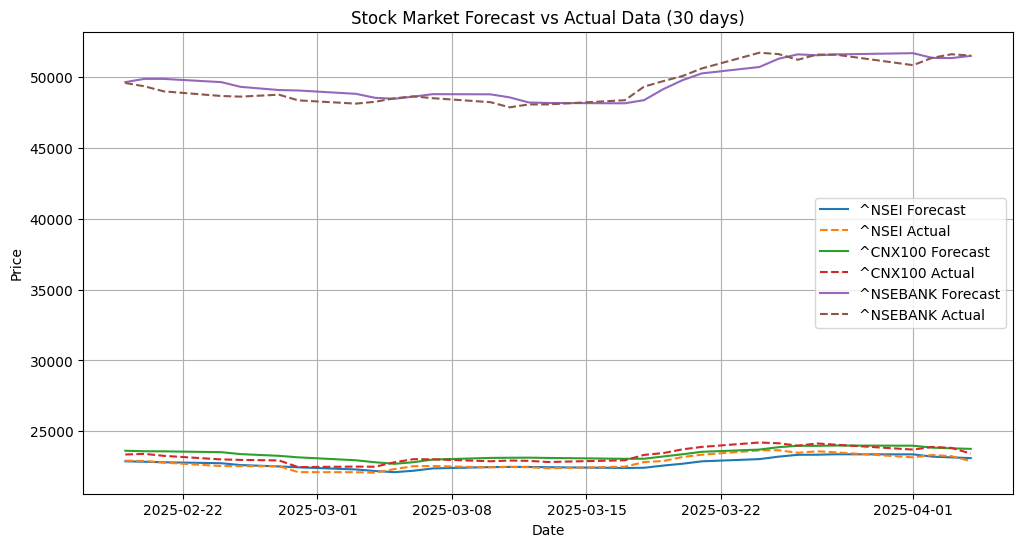

Epoch 1/250


c:\Users\pande\anaconda3\envs\MachineLearning\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


126/126 ━━━━━━━━━━━━━━━━━━━━ 11s 60ms/step - loss: 0.0462 - learning_rate: 0.0010
Epoch 2/250
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - loss: 0.0049 - learning_rate: 0.0010
Epoch 3/250
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step - loss: 0.0029 - learning_rate: 0.0010
Epoch 4/250
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step - loss: 0.0021 - learning_rate: 0.0010
Epoch 5/250
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step - loss: 0.0017 - learning_rate: 0.0010
Epoch 6/250
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step - loss: 0.0012 - learning_rate: 0.0010
Epoch 7/250
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 64ms/step - loss: 0.0011 - learning_rate: 0.0010
Epoch 8/250
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 64ms/step - loss: 0.0011 - learning_rate: 0.0010
Epoch 9/250
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step - loss: 8.5718e-04 - learning_rate: 0.0010
Epoch 10/250
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 64ms/step - loss: 9.1173e-04 - learning_rate: 0.0010
Epoch 11/250
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step - loss: 7.5611e-0

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step
📊 Performance Metrics for ^NSEI:
RMSE: 462.47
MAE: 410.95
MAPE: 1.81%
R² Score: 0.0440

Epoch 1/250


c:\Users\pande\anaconda3\envs\MachineLearning\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


140/140 ━━━━━━━━━━━━━━━━━━━━ 12s 59ms/step - loss: 0.0357 - learning_rate: 0.0010
Epoch 2/250
140/140 ━━━━━━━━━━━━━━━━━━━━ 9s 62ms/step - loss: 0.0056 - learning_rate: 0.0010
Epoch 3/250
140/140 ━━━━━━━━━━━━━━━━━━━━ 9s 63ms/step - loss: 0.0032 - learning_rate: 0.0010
Epoch 4/250
140/140 ━━━━━━━━━━━━━━━━━━━━ 9s 63ms/step - loss: 0.0022 - learning_rate: 0.0010
Epoch 5/250
140/140 ━━━━━━━━━━━━━━━━━━━━ 9s 64ms/step - loss: 0.0016 - learning_rate: 0.0010
Epoch 6/250
140/140 ━━━━━━━━━━━━━━━━━━━━ 9s 64ms/step - loss: 0.0015 - learning_rate: 0.0010
Epoch 7/250
140/140 ━━━━━━━━━━━━━━━━━━━━ 9s 63ms/step - loss: 0.0012 - learning_rate: 0.0010
Epoch 8/250
140/140 ━━━━━━━━━━━━━━━━━━━━ 9s 64ms/step - loss: 0.0011 - learning_rate: 0.0010
Epoch 9/250
140/140 ━━━━━━━━━━━━━━━━━━━━ 9s 65ms/step - loss: 8.7526e-04 - learning_rate: 0.0010
Epoch 10/250
140/140 ━━━━━━━━━━━━━━━━━━━━ 9s 64ms/step - loss: 8.4757e-04 - learning_rate: 0.0010
Epoch 11/250
140/140 ━━━━━━━━━━━━━━━━━━━━ 9s 64ms/step - loss: 6.9195e-0

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step
📊 Performance Metrics for ^CNX100:
RMSE: 551.39
MAE: 497.91
MAPE: 2.12%
R² Score: -0.1244

Epoch 1/250


c:\Users\pande\anaconda3\envs\MachineLearning\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


117/117 ━━━━━━━━━━━━━━━━━━━━ 11s 62ms/step - loss: 0.0565 - learning_rate: 0.0010
Epoch 2/250
117/117 ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/step - loss: 0.0067 - learning_rate: 0.0010
Epoch 3/250
117/117 ━━━━━━━━━━━━━━━━━━━━ 8s 64ms/step - loss: 0.0052 - learning_rate: 0.0010
Epoch 4/250
117/117 ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/step - loss: 0.0036 - learning_rate: 0.0010
Epoch 5/250
117/117 ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/step - loss: 0.0032 - learning_rate: 0.0010
Epoch 6/250
117/117 ━━━━━━━━━━━━━━━━━━━━ 7s 64ms/step - loss: 0.0020 - learning_rate: 0.0010
Epoch 7/250
117/117 ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/step - loss: 0.0023 - learning_rate: 0.0010
Epoch 8/250
117/117 ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/step - loss: 0.0017 - learning_rate: 0.0010
Epoch 9/250
117/117 ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/step - loss: 0.0013 - learning_rate: 0.0010
Epoch 10/250
117/117 ━━━━━━━━━━━━━━━━━━━━ 8s 64ms/step - loss: 0.0012 - learning_rate: 0.0010
Epoch 11/250
117/117 ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/step - loss: 0.0012 - learning

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step


ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^NSEAUTO']: YFTzMissingError('possibly delisted; no timezone found')
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^NSEIT']: YFTzMissingError('possibly delisted; no timezone found')
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^NSEMETAL']: YFTzMissingError('possibly delisted; no timezone found')
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^NSEENERGY']: YFTzMissingError('possibly delisted; no timezone found')
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^NSEPHARMA']: YFTzMissingError('possibly delisted; no timezone found')
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^NSEFMCG']: YFTzMissingError('possibly delisted; no timezone found')
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^NSEPSU']: YFTzMissingError('possibly delisted; no timezone found')
ERROR:yfinance:
1 Failed download:


📊 Performance Metrics for ^NSEBANK:
RMSE: 579.76
MAE: 468.11
MAPE: 0.94%
R² Score: 0.8187

⚠️ Warning: No data found for ^NSEAUTO. Skipping...
⚠️ Warning: No data found for ^NSEIT. Skipping...
⚠️ Warning: No data found for ^NSEMETAL. Skipping...
⚠️ Warning: No data found for ^NSEENERGY. Skipping...
⚠️ Warning: No data found for ^NSEPHARMA. Skipping...
⚠️ Warning: No data found for ^NSEFMCG. Skipping...
⚠️ Warning: No data found for ^NSEPSU. Skipping...


ERROR:yfinance:['^NSEREALTY']: YFTzMissingError('possibly delisted; no timezone found')
ERROR:yfinance:
1 Failed download:


⚠️ Warning: No data found for ^NSEREALTY. Skipping...


ERROR:yfinance:['^NSEINFRA']: YFTzMissingError('possibly delisted; no timezone found')


⚠️ Warning: No data found for ^NSEINFRA. Skipping...

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^NSEMIDCAP']: YFTzMissingError('possibly delisted; no timezone found')
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^NSESMALLCAP']: YFTzMissingError('possibly delisted; no timezone found')



⚠️ Warning: No data found for ^NSEMIDCAP. Skipping...
⚠️ Warning: No data found for ^NSESMALLCAP. Skipping...


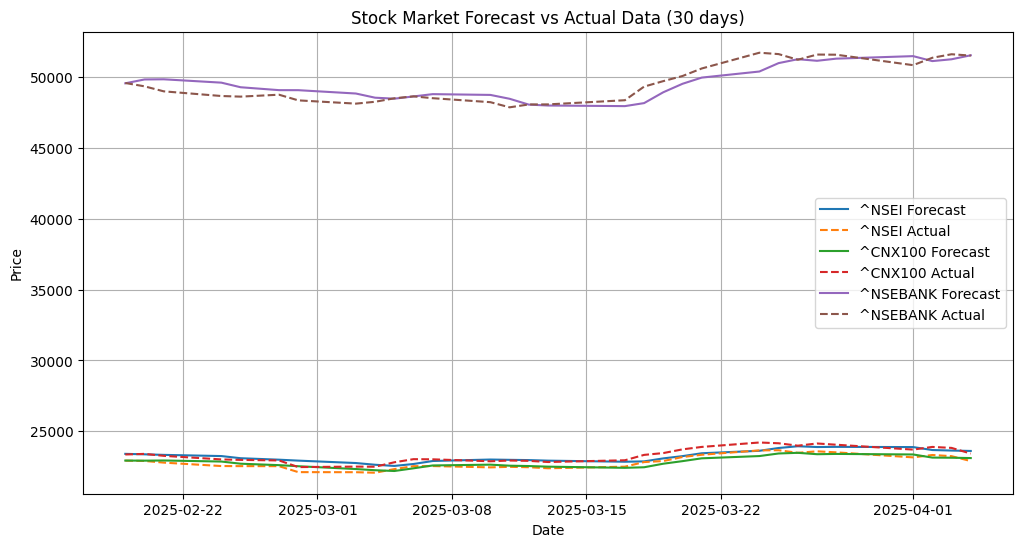

In [25]:
nifty_indices = ['^NSEI', '^CNX100', '^NSEBANK', '^NSEAUTO', '^NSEIT', '^NSEMETAL', '^NSEENERGY', '^NSEPHARMA', '^NSEFMCG', '^NSEPSU', '^NSEREALTY', '^NSEINFRA', '^NSEMIDCAP', '^NSESMALLCAP']
forecast_multiple_indices(nifty_indices, epoch=50)
forecast_multiple_indices(nifty_indices, epoch=100)
forecast_multiple_indices(nifty_indices, epoch=150)
forecast_multiple_indices(nifty_indices, epoch=200)
forecast_multiple_indices(nifty_indices, epoch=250)
